In [1]:
import os, sys
parent_dir = os.path.realpath('..')
sys.path.append(parent_dir)

In [2]:
import argparse
import logging
import os
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from src.libs.train_valid_test_utils import TrainValidEvaluate

import matplotlib.pyplot as plt

In [3]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
stream_handler = logging.StreamHandler()
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)

In [4]:
np.random.seed(42)

# Data

## data analysis

In [5]:
parent_dir

'/Users/a10961/Documents/42dot/accidentdetection_lv2'

In [6]:
data = pd.read_csv(f'{parent_dir}/data/processed/6dof/6dof_F_uniform_input.csv')
data

,Unnamed: 0,Fx,Fy,Fz,Mx,My,Mz,rx,ry,rz,...,vz,wx,wy,wz,e1,e2,e3,dvx,dvy,dvz
0,0,-0.267103,-0.202699,0.770637,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.0,0.0,0.0,0.1,0.2,0.3,-0.267103,-0.202699,0.770637
1,1,-0.783751,0.452041,-0.751070,0.0,0.0,0.0,-8.086109e-08,-2.338268e-07,1.216049e-07,...,-0.000032,0.0,0.0,0.0,0.1,0.2,0.3,-0.783751,0.452041,-0.751070
2,2,0.516694,-0.699261,0.680525,0.0,0.0,0.0,-2.959466e-07,-8.430528e-07,7.135529e-08,...,-0.000096,0.0,0.0,0.0,0.1,0.2,0.3,0.516694,-0.699261,0.680525
3,3,0.885389,0.170987,0.718723,0.0,0.0,0.0,-2.063443e-08,-1.675044e-06,-2.996237e-09,...,0.000143,0.0,0.0,0.0,0.1,0.2,0.3,0.885389,0.170987,0.718723
4,4,0.844885,0.611682,-0.010581,0.0,0.0,0.0,7.065303e-07,-2.364906e-06,8.706100e-08,...,0.000413,0.0,0.0,0.0,0.1,0.2,0.3,0.844885,0.611682,-0.010581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,9996,0.172142,0.435237,-0.045802,0.0,0.0,0.0,-1.167817e-01,-1.506775e-01,9.632050e-02,...,0.008879,0.0,0.0,0.0,0.1,0.2,0.3,0.172142,0.435237,-0.045802
9997,9997,-0.715178,-0.775136,0.992664,0.0,0.0,0.0,-1.168189e-01,-1.506971e-01,9.633716e-02,...,0.008949,0.0,0.0,0.0,0.1,0.2,0.3,-0.715178,-0.775136,0.992664
9998,9998,0.366387,0.191162,-0.883123,0.0,0.0,0.0,-1.168563e-01,-1.507167e-01,9.635405e-02,...,0.008983,0.0,0.0,0.0,0.1,0.2,0.3,0.366387,0.191162,-0.883123
9999,9999,0.849927,0.807182,-0.590503,0.0,0.0,0.0,-1.168936e-01,-1.507359e-01,9.637081e-02,...,0.008856,0.0,0.0,0.0,0.1,0.2,0.3,0.849927,0.807182,-0.590503


In [7]:
data.columns

Index(['Unnamed: 0', 'Fx', 'Fy', 'Fz', 'Mx', 'My', 'Mz', 'rx', 'ry', 'rz',
       'vx', 'vy', 'vz', 'wx', 'wy', 'wz', 'e1', 'e2', 'e3', 'dvx', 'dvy',
       'dvz'],
      dtype='object')

In [8]:
data.drop(columns=['Fx', 'Fy', 'Fz', 'Mx', 'My', 'Mz', 'wx', 'wy', 'wz', 'e1', 'e2', 'e3'], inplace=True)
data.head()

,Unnamed: 0,rx,ry,rz,vx,vy,vz,dvx,dvy,dvz
0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,-0.267103,-0.202699,0.770637
1,1,-8.086109e-08,-2.338268e-07,1.216049e-07,-0.000426,-0.000467,-0.000032,-0.783751,0.452041,-0.751070
2,2,-2.959466e-07,-8.430528e-07,7.135529e-08,-0.000113,-0.000559,-0.000096,0.516694,-0.699261,0.680525
3,3,-2.063443e-08,-1.675044e-06,-2.996237e-09,0.000099,-0.001047,0.000143,0.885389,0.170987,0.718723
4,4,7.065303e-07,-2.364906e-06,8.706100e-08,0.000548,-0.000684,0.000413,0.844885,0.611682,-0.010581


In [9]:
# F: Force
# M: Momentum
# r: state vector
# v: velocity
# w: angular velocity
# e: euler
# dv: acceleration

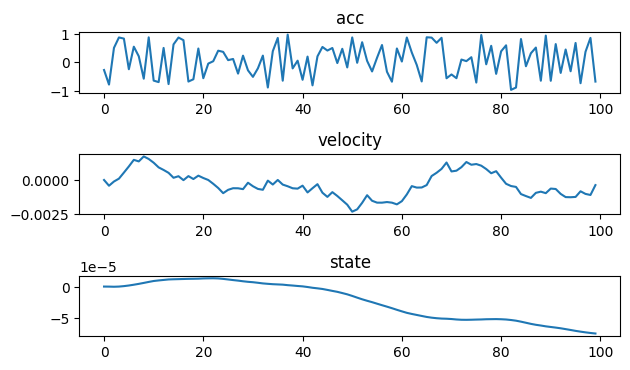

In [10]:
i = 100
t = range(len(data[:i]))
plt.figure()
# plt.subplot(4, 1, 1)
# plt.title('force')
# plt.plot(t, data['Fx'][:i])
plt.subplot(4, 1, 2)
plt.plot(t, data['dvx'][:i])
plt.title('acc')
plt.subplot(4, 1, 3)
plt.title('velocity')
plt.plot(t, data['vx'][:i])
plt.subplot(4, 1, 4)
plt.title('state')
plt.plot(t, data['rx'][:i])
plt.tight_layout()

## data loader

In [11]:
from torch.utils.data import Dataset


class FDataset(Dataset):
    def __init__(self, total_data: pd.DataFrame, input_dim: int, data_type: str, predict_column: str):
        self.data_input_sequence_length = input_dim
        self.total_data_num = len(total_data) - input_dim
        self.data_type = data_type
        self.output_col = predict_column
        # train_last, valid_last : last index number for train, valid (abs value)
        train_data_num = self.total_data_num*8//10
        valid_data_num = self.total_data_num*9//10
        if self.data_type == 'train':
            data = total_data[:train_data_num + input_dim]
        elif self.data_type == 'valid':
            data = total_data[train_data_num: valid_data_num + input_dim]
        elif self.data_type == 'test':
            data = total_data[valid_data_num:]
        self.data = data

    def __len__(self):
        # return len(self.data)
        return len(self.data) - self.data_input_sequence_length - 1

    def __getitem__(self, idx):
        if self.output_col == 'acc':
            input_col = ['rx','ry','rz','vx','vy','vz']
            output_col = ['dvx', 'dvy', 'dvz']
        elif self.output_col == 'vel':
            input_col = ['rx','ry','rz','dvx','dvy','dvz']
            output_col = ['vx', 'vy', 'vz']
        elif self.output_col == 'state':
            input_col = ['vx', 'vy', 'vz','dvx','dvy','dvz']
            output_col = ['rx', 'ry', 'rz']
        x = np.array(self.data[input_col])[idx: idx+self.data_input_sequence_length]
        y = np.array(self.data[output_col])[idx+self.data_input_sequence_length]
        t = np.array(list(range(idx, idx+self.data_input_sequence_length)))
        return t, x, y

In [12]:
train_dataset = FDataset(total_data=data, data_type="train", predict_column='acc', input_dim=20)

In [13]:
train_loader = DataLoader(train_dataset, batch_size=5)

In [14]:
for i, (t, x, y) in enumerate(train_loader):
    try:
        a = x
    except:
        print(i)

In [15]:
print(t, x, y)

tensor([[7980, 7981, 7982, 7983, 7984, 7985, 7986, 7987, 7988, 7989, 7990, 7991,
         7992, 7993, 7994, 7995, 7996, 7997, 7998, 7999],
        [7981, 7982, 7983, 7984, 7985, 7986, 7987, 7988, 7989, 7990, 7991, 7992,
         7993, 7994, 7995, 7996, 7997, 7998, 7999, 8000],
        [7982, 7983, 7984, 7985, 7986, 7987, 7988, 7989, 7990, 7991, 7992, 7993,
         7994, 7995, 7996, 7997, 7998, 7999, 8000, 8001]]) tensor([[[-0.0484, -0.1145,  0.0686, -0.0316, -0.0097,  0.0012],
         [-0.0485, -0.1145,  0.0686, -0.0315, -0.0098,  0.0011],
         [-0.0485, -0.1145,  0.0686, -0.0314, -0.0100,  0.0015],
         [-0.0485, -0.1145,  0.0686, -0.0310, -0.0101,  0.0016],
         [-0.0485, -0.1145,  0.0686, -0.0313, -0.0103,  0.0022],
         [-0.0486, -0.1145,  0.0687, -0.0308, -0.0103,  0.0024],
         [-0.0486, -0.1146,  0.0687, -0.0312, -0.0102,  0.0022],
         [-0.0486, -0.1146,  0.0687, -0.0310, -0.0098,  0.0025],
         [-0.0486, -0.1146,  0.0687, -0.0304, -0.0099,  0.0022

# Modeling

In [ ]:
class FLSTM(nn.Module):
    def __init__(
        self,
        input_dim=6,
        lstm_hidden_dim=128,
        output_dim=3,
        num_layers=1,
        bidirectional=False,
    ):
        super().__init__()
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=lstm_hidden_dim,
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=True,
        )

        self.hidden_dim = lstm_hidden_dim * num_layers

        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()

        self.bn0 = nn.BatchNorm1d(self.hidden_dim // 2)

        self.fc0 = nn.Linear(self.hidden_dim, self.hidden_dim // 2)
        self.fc1 = nn.Linear(self.hidden_dim // 2, output_dim)

    def forward(self, seq_x):
        _, (h_t, c_t) = self.lstm(
            seq_x.float()
        )  # h_t dim = [num_layers, batch_size, LSTM_output_dim]
        output = h_t.permute(
            1, 0, 2
        )  # output dim = [batch_size, num_layers, LSTM_output_dim]
        output = self.flatten(
            output
        )  # output dim = [batch_size, num_layers*LSTM_output_dim]
        output = self.relu(
            self.bn0(self.fc0(output))
        )  # output = [batch_size, fc0_output_dim]
        output = self.fc1(output)  # output = [batch_size, fc1_output_dim]

        return output


In [ ]:
model = FLSTM()

In [ ]:
y_test = model(x)

In [ ]:
y_test

In [ ]:
model

# Train

## general functions

In [ ]:
# args
class Args:
    def __init__(
        self,
        model_name='F_uniform_LSTM',
        data_dir='data.csv',
        device='cpu',
        input_sequence_length=40,
        hidden_dim1=100,
        loss='L2',
        batch_size=32,
        num_layers=1,
        weight_decay=1e-6,
        learning_rate=1e-3,
        n_epochs=500,
        logging_level='info',
        predict_col='state'
    ):
        self.model_name=model_name
        self.data_dir=data_dir
        self.device=device
        self.input_sequence_length=input_sequence_length
        self.hidden_dim1=hidden_dim1
        self.loss=loss
        self.batch_size=batch_size
        self.num_layers=num_layers
        self.weight_decay=weight_decay
        self.learning_rate=learning_rate
        self.n_epochs=n_epochs
        self.logging_level=logging_level
        self.predict_column=predict_col
        
logging_dict = {
    "debug": logging.DEBUG,
    "info": logging.INFO,
    "warning": logging.WARNING,
    "error": logging.ERROR,
    "critical": logging.CRITICAL,
}

loss_funcs = {"L2": nn.MSELoss()}
args = Args()

In [ ]:
# initial setting
predict_col = 'acc'
save_name = "acc&vel_to_state"

# data
train_dataset = FDataset(total_data=data, data_type="train", predict_column=predict_col, input_dim=args.input_sequence_length)
train_loader = DataLoader(train_dataset, batch_size=5)

# model
model = FLSTM()

# train
logger.setLevel(logging_dict[args.logging_level])
save_dir = f"{parent_dir}/models/{args.model_name}/{save_name}"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

device = args.device if torch.cuda.is_available() else "cpu"

train_dataset = FDataset(total_data=data, data_type="train", predict_column=args.predict_column, input_dim=args.input_dim)
valid_dataset = FDataset(total_data=data, data_type="valid", predict_column=args.predict_column, input_dim=args.input_dim)
test_dataset = FDataset(total_data=data, data_type="test", predict_column=args.predict_column, input_dim=args.input_dim)

train_loader = DataLoader(dataset=train_dataset, batch_size=args.batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=args.batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=args.batch_size)

pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params

md_file_name = os.path.join(save_dir, f"{save_name}.md")
with open(md_file_name, "w") as f:
    f.write("### Argument Values\n")
    for k, v in args.__dict__.items():
        f.write(f"- {k}={v}\n")
    f.write("\n### Model Architecture\n")
    f.write(f"```{model}```\n")
    f.write("\n### Parameter Number\n")
    f.write(f"- {pytorch_total_params}")
    
lstm_input_dim = len(train_dataset[0][1][-1])
model = FLSTM(
    input_dim = lstm_input_dim,
    lstm_hidden_dim=args.hidden_dim1,
    output_dim=3,
    num_layers=args.num_layers,
    bidirectional=False
)
logging.info(model)

criterion = loss_funcs[args.loss]

lr = args.learning_rate
optimizer = torch.optim.Adam(
    model.parameters(), lr=lr, weight_decay=args.weight_decay
)

save_name = os.path.join(save_dir, f"{save_name}.pth")
logging.info(save_name)

logging.info("*--------Start Training--------*")

train_valid_evaluate = TrainValidEvaluate(
    model=model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    n_epochs=args.n_epochs,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    path=save_name,
    logging=logging,
    # writer=writer
)
train_valid_evaluate.sin_train()
train_valid_evaluate.sin_test()
# writer.flush()

logging.info(
    f"TEST SCORE :: \n \ttest MAPE={train_valid_evaluate.avg_test_mape:.4f} \n\ttest loss={train_valid_evaluate.avg_test_loss:.4f}"
)

pre_ = train_valid_evaluate.test_prediction_result
true_ = train_valid_evaluate.test_target_result


# i = 200
i = len(true_)

for j, sym in enumerate(['x','y','z']):
    plt.figure()
    true_values = [x[-1][j] for x in true_[:i]]
    pre_values = [x[-1][j] for x in pre_[:i]]
    min_, max_ = min(min(true_values), min(pre_values)), max(max(true_values), max(pre_values))
    gap = (max_-min_)/10
    min_, max_ = min_-gap, max_+gap
    plt.subplot(2, 1, 1)
    plt.title('true')
    plt.plot(range(i), true_values, label=f'{predict_col}_{sym}')
    plt.legend()
    plt.ylim([min_, max_])
    plt.subplot(2, 1, 2)
    plt.title('predict')
    plt.plot(range(i), pre_values, label=f'{predict_col}_{sym}')
    plt.legend()
    plt.ylim([min_, max_])
    plt.tight_layout()

## input: [0, t] 구간의 acc, vel → output: [t+1] 시점의 state

In [ ]:
class Args:
    def __init__(
        self,
        model_name='F_uniform_LSTM',
        data_dir='data.csv',
        device='cpu',
        input_dim=20,
        hidden_dim1=100,
        loss='L2',
        batch_size=16,
        num_layers=1,
        weight_decay=1e-6,
        learning_rate=1e-3,
        n_epochs=500,
        logging_level='info',
        predict_col='state'
    ):
        self.model_name=model_name
        self.data_dir=data_dir
        self.device=device
        self.input_dim=input_dim
        self.hidden_dim1=hidden_dim1
        self.loss=loss
        self.batch_size=batch_size
        self.num_layers=num_layers
        self.weight_decay=weight_decay
        self.learning_rate=learning_rate
        self.n_epochs=n_epochs
        self.logging_level=logging_level
        self.predict_column=predict_col

args = Args()
args.n_epochs

In [ ]:
# from torch.utils.tensorboard import SummaryWriter


np.random.seed(42)

logger = logging.getLogger()
logger.setLevel(logging.INFO)
formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
stream_handler = logging.StreamHandler()
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)


logging_dict = {
    "debug": logging.DEBUG,
    "info": logging.INFO,
    "warning": logging.WARNING,
    "error": logging.ERROR,
    "critical": logging.CRITICAL,
}
logger.setLevel(logging_dict[args.logging_level])
save_name = f"acc&vel_to_state"
save_dir = f"{parent_dir}/models/{args.model_name}/{save_name}"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

device = args.device if torch.cuda.is_available() else "cpu"

train_dataset = FDataset(total_data=data, data_type="train", predict_column=args.predict_column, input_dim=args.input_dim)
valid_dataset = FDataset(total_data=data, data_type="valid", predict_column=args.predict_column, input_dim=args.input_dim)
test_dataset = FDataset(total_data=data, data_type="test", predict_column=args.predict_column, input_dim=args.input_dim)

train_loader = DataLoader(dataset=train_dataset, batch_size=args.batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=args.batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=args.batch_size)

In [ ]:
md_file_name = os.path.join(save_dir, f"{save_name}.md")
with open(md_file_name, "w") as f:
    f.write("### Argument Values\n")
    for k, v in args.__dict__.items():
        f.write(f"- {k}={v}\n")

In [ ]:
lstm_input_dim = len(train_dataset[0][1][-1])
model = FLSTM(
    input_dim = lstm_input_dim,
    lstm_hidden_dim=args.hidden_dim1,
    output_dim=3,
    num_layers=args.num_layers,
    bidirectional=False
)
print(model)

# hyper-params
loss_funcs = {"L2": nn.MSELoss()}
criterion = loss_funcs[args.loss]

lr = args.learning_rate
optimizer = torch.optim.Adam(
    model.parameters(), lr=lr, weight_decay=args.weight_decay
)

save_name = os.path.join(save_dir, f"{save_name}.pth")
logging.info(save_name)

In [ ]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params

In [ ]:
logging.info("*--------Start Training--------*")

train_valid_evaluate = TrainValidEvaluate(
    model=model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    n_epochs=args.n_epochs,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    path=save_name,
    logging=logging,
    # writer=writer
)
train_valid_evaluate.sin_train()
train_valid_evaluate.sin_test()
# writer.flush()

logging.info(
    f"TEST SCORE :: \n \ttest MAPE={train_valid_evaluate.avg_test_mape:.4f} \n\ttest loss={train_valid_evaluate.avg_test_loss:.4f}"
)

In [ ]:
pre_ = train_valid_evaluate.test_prediction_result
true_ = train_valid_evaluate.test_target_result

In [ ]:
# i = 200
i = len(true_)

nrows, ncols = 3, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,10))

for j, sym in enumerate(['x','y','z']):
    true_values = [x[-1][j] for x in true_[:i]]
    pre_values = [x[-1][j] for x in pre_[:i]]
    min_, max_ = min(min(true_values), min(pre_values)), max(max(true_values), max(pre_values))
    gap = (max_-min_)/10
    min_, max_ = min_-gap, max_+gap
    
    ax = axes[j][0]
    ax.set_title('true')
    ax.plot(range(i), true_values, label=f'r_{sym}')
    ax.legend()
    ax.set_ylim([min_, max_])

    ax = axes[j][1]
    ax.set_title('predict')
    ax.plot(range(i), pre_values, label=f'r_{sym}')
    ax.legend()
    ax.set_ylim([min_, max_])
plt.tight_layout()
    

## input: [0, t] 구간의 state, vel → output: [t+1] 시점의 acc

In [ ]:
# initial setting
predict_col = 'acc'
save_name = "state&vel_to_acc"


# train
logger.setLevel(logging_dict[args.logging_level])
save_dir = f"{parent_dir}/models/{args.model_name}/{save_name}"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

device = args.device if torch.cuda.is_available() else "cpu"

train_dataset = FDataset(total_data=data, data_type="train", predict_column=args.predict_column, input_dim=args.input_sequence_length)
valid_dataset = FDataset(total_data=data, data_type="valid", predict_column=args.predict_column, input_dim=args.input_sequence_length)
test_dataset = FDataset(total_data=data, data_type="test", predict_column=args.predict_column, input_dim=args.input_sequence_length)

train_loader = DataLoader(dataset=train_dataset, batch_size=args.batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=args.batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=args.batch_size)

pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params

md_file_name = os.path.join(save_dir, f"{save_name}.md")
with open(md_file_name, "w") as f:
    f.write("### Argument Values\n")
    for k, v in args.__dict__.items():
        f.write(f"- {k}={v}\n")
    f.write("\n### Model Architecture\n")
    f.write(f"```{model}```\n")
    f.write("\n### Parameter Number\n")
    f.write(f"- {pytorch_total_params}")
    
lstm_input_dim = len(train_dataset[0][1][-1])
model = FLSTM(
    input_dim = lstm_input_dim,
    lstm_hidden_dim=args.hidden_dim1,
    output_dim=3,
    num_layers=args.num_layers,
    bidirectional=False
)
logging.info(model)

criterion = loss_funcs[args.loss]

lr = args.learning_rate
optimizer = torch.optim.Adam(
    model.parameters(), lr=lr, weight_decay=args.weight_decay
)

save_name = os.path.join(save_dir, f"{save_name}.pth")
logging.info(save_name)

logging.info("*--------Start Training--------*")

train_valid_evaluate = TrainValidEvaluate(
    model=model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    n_epochs=args.n_epochs,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    path=save_name,
    logging=logging,
    # writer=writer
)
train_valid_evaluate.sin_train()
train_valid_evaluate.sin_test()
# writer.flush()

logging.info(
    f"TEST SCORE :: \n \ttest MAPE={train_valid_evaluate.avg_test_mape:.4f} \n\ttest loss={train_valid_evaluate.avg_test_loss:.4f}"
)

pre_ = train_valid_evaluate.test_prediction_result
true_ = train_valid_evaluate.test_target_result


# i = 200
i = len(true_)

nrows, ncols = 3, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,10))

for j, sym in enumerate(['x','y','z']):
    true_values = [x[-1][j] for x in true_[:i]]
    pre_values = [x[-1][j] for x in pre_[:i]]
    min_, max_ = min(min(true_values), min(pre_values)), max(max(true_values), max(pre_values))
    gap = (max_-min_)/10
    min_, max_ = min_-gap, max_+gap
    
    ax = axes[j][0]
    ax.set_title('true')
    ax.plot(range(i), true_values, label=f'{predict_col}_{sym}')
    ax.legend()
    ax.set_ylim([min_, max_])

    ax = axes[j][1]
    ax.set_title('predict')
    ax.plot(range(i), pre_values, label=f'{predict_col}_{sym}')
    ax.legend()
    ax.set_ylim([min_, max_])
plt.tight_layout()
    